# Lecture 16: Quantum Chemistry

### Overview

In this notebook we will use Cirq to demonstrate some of the basics of **quantum chemistry**, a study of chemistry focusing on the property and behavior of particles that make up atoms. 

Here we're going to focus on the **electron**, a type of small, light particle (i.e. fermion) that makes up matter. Electrons and their interactions play a large role in the determining physical and chemical properties of atoms and molecules including atomic size (number of electrons), bonds (electrons availble in valence shells), etc. 

In quantum mechanics, the physical state of an electron is described by a **wavefunction**. The wavefunction is paramaterized with probability amplitudes that correspond to the likelyhood of finding the system in some state. 

In quantum simulation, we want to **model the dynamic evolution of the wavefunction under some Hamiltonian H** as per
Schrödinger’s equation, ie. how the state changes with the application of some operator.


### Libraries & Packages

[**OpenFermion**](https://github.com/quantumlib/OpenFermion) is an open-source software library aimed at enabling the simulation of fermionic and bosonic models
and quantum chemistry problems on quantum hardware. We'll use OpenFermion to help us go from a molecular specification to a
quantum circuit for solving or studying the electronic structure problem on a quantum computer.

[**Psi4**](http://www.psicode.org/) and [**Pyscf**](https://sunqm.github.io/pyscf/) are open-source packages that takes in physical constants as inputs (ab initio) and solves the electronic Schrodinger equation given the positions of the nuclei and number of electrons. This gives us useful information about other properties of the system like electron density.

[**OpenFermion-Psi4**](https://github.com/quantumlib/OpenFermion-Psi4) and [**OpenFermion-Pyscf**](https://github.com/quantumlib/OpenFermion-PySCF) are OpenFermion plugins that interface with Psi4 and PySCF.

In [0]:
# Install/import libraries

# OpenFermion
# Install OpenFermion libraries
!pip install openfermion openfermionpsi4 openfermioncirq pyscf openfermionpyscf
import openfermion as of
from openfermion.hamiltonians import MolecularData

google-auth 1.11.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.2.0 which is incompatible.
cirq 0.4.0 has requirement matplotlib~=2.2, but you'll have matplotlib 3.2.0 which is incompatible.


In [0]:
# Psi4
# Set up a local conda environment for psi4
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
# Append path to be able to run packages installed with conda
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
# Install psi4 from Anaconda
!conda install -c psi4 psi4 -y

--2020-03-11 17:57:37--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh.6’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M  79.4MB/s    in 0.7s    

2020-03-11 17:57:37 (79.4 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh.6’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing

In [0]:
# OpenFermionPsi4
# Import opemfermionpsi4
import openfermionpsi4
from openfermionpsi4 import run_psi4

In [0]:
# OpenFermionPySCF
import openfermionpyscf as ofpyscf

### 0. Problem Specification

Our initial step is to specify our problem of interest.

In this notebook, we'll study molecular hydrogen, $H_2$. Our problem to solve will be **what bond length molecular hydrogen has**. We'll then compare our solution to experimental measurements from literature. 

The bond length is the distance between the nuclei of our two hydrogen atoms. It is an important determinant of a molecule's properties. For example, the longer the bond length, the easier it is to break apart our two hydrogens. Knowing the natural bond length allows researchers to do further simulations and is an important parameter for experimental tests such as spectroscopic transitions. 

![alt text](https://www.brooklyn.cuny.edu/bc/ahp/SDgraphics/PSgraphics/Molec.Hydrogen.GIF)

[[Image source]](https://www.brooklyn.cuny.edu/bc/ahp/SDgraphics/PSgraphics/Molec.Hydrogen.GIF)



## 1.0 Molecular specification
First we'll define $H_2$ in OpenFermion as `h2_molecule` by specifying its geometry, basis, multipilicty, and charge.

### 1.1 Geometry

In specifying the geometry of H_2, we're assuming the [Born-Oppenheimer approximation](https://en.wikipedia.org/wiki/Born%E2%80%93Oppenheimer_approximation). This means we can treat the nuclei as fixed point charges and consider the ground state electronic energy as a function of the nuclei's positions.  

The Hamiltonian operator (a function describing the total energy of the system) can thus be expressed as:
![alt text](https://drive.google.com/uc?id=1gyibJIhO844k1FD7WqpemSI9bwDNTz8_)

where we have:

- atomic units of $\hbar$ = 1
- $r_i$, the positions of electrons
- $R_i$, the positions of
nuclei
- $Z_i$, the charges of nuclei


In our problem, our geometry is the nuclear positions, that can be specified by x, y, and z coordinates and atom labels (our two hydrogen atoms):

In [0]:
bond_length = 0.74
geometry = [['H', [0., 0., 0.]],
            ['H', [0., 0., bond_length]]]

### 1.2 Spin Multiplicity

The spin multiplicity is the number of possible orientations of spin angular momentum:

$multiplicity = 2S + 1$

where $S$ is the total spin which is typically the number of unpaired electrons. Molecular hydrogen has two electrons that are pairs, so S = 0 and multiplicity = 1.

In order to know S, some intution about electronic structure (what we're looking for, a function of the bond length) is needed. So, oftentimes an iterative process is used by taking an initial guess for S, solving the system, then changing S to see which one is likely to be the most physically accurate.

In [0]:
multiplicity = 1

### 1.3 Charge

We know electrons are negatively charged and protons are positively charged, so 

$ charge = (# protons) - (# electrons) $

We're going to be looking at neural hydrogen, where the number of electrons and protons are the same, so our charge is 0.

In [0]:
charge = 0

### 1.3 Basis Set

A basis set is a set of functions combined in linear combinations to create molecular orbitals. These functions for molecular orbitals are then used to construct wavefunctions for the electronic states which describe the electronic states of molecules: 

> basis sets (Gaussian functions) $\rightarrow$ molecular orbitals (sum of basis sets)$\rightarrow$ electronic states of molecules (wavefunction)

Common basis sets expressed as sums of Gaussians can be found [here](https://www.basissetexchange.org/). We're going to use a minimal basis set, `sto-3g`, 3 Gaussians used to approximate Slater-type orbitals.

In [0]:
basis = 'sto-3g'

In [0]:
basis = 

### 1.4 Define the molecule

Now by specifying its geometry, basis, multipilicty, and charge, we'll define the $H_2$ molecule, `h2_molecule`

In [0]:
# define H_2 molecule
h2_molecule = MolecularData(geometry, basis, multiplicity, charge)

We can get information about our molecule's:
* number of atoms using `molecule.n_atoms`
* number of electrons using `molecule.n_electrons`

as shown below!

In [0]:
print('This molecule has {} atoms and {} electrons.'.format(
    h2_molecule.n_atoms, h2_molecule.n_electrons))
for atom, atomic_number in zip(h2_molecule.atoms, h2_molecule.protons):
    print('Contains {} atom, which has {} protons.'.format(
        atom, atomic_number))

This molecule has 2 atoms and 2 electrons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.


## 2.0 Numerical processing

After specifying the molecule, the electronic structure problem may be written in the form of a second quantized electronic Hamiltonian as:

![alt text](https://drive.google.com/uc?id=17a4BK5KHRGBbv_eUeraSJcbJObnEXCNi)

In this form we have:
- $R$, the fixed positions of
nuclei
- $a_j$, $a_k$, $a_l$, the annhilation operators
- $a_{i}^\dagger$, $a_{j}^\dagger$, the creation operators
- $h_ij$ and $h_{ijkl}$, the one and two-electron integerals, coefficients that depend on the physical system being described. These are defined by the basis set chosen, sto-3g. Using the OpenFermion-Psi4 plugin, these can be obtained in the MO basis in the Psi4 electronic strucutre code by executing `run_psi4`

We want to calculate the lowest eignvalue of this Hamiltonian, which corresponds to the ground state energy.

#### 2.1 One and Two-Electron Integrals

$h_ij$ and $h_{ijkl}$, the one and two-electron integerals, are coefficients in the Hamiltonian that depend on the physical system being described. These are defined by the basis set chosen

`run_pyscf` runs a PySCF calculation for one and two-electron integrals using the Hartree-Fock method. 

In [0]:
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1

h2_molecule = ofpyscf.run_pyscf(h2_molecule,
                    run_scf=run_scf,
                    run_mp2=run_mp2,
                    run_cisd=run_cisd,
                    run_ccsd=run_ccsd,
                    run_fci=run_fci)

The MP2, CISD, CCSD, and FCI energies are used to improve upon the Hartree-Fock method. These energies are descriptions of correlated motions of electrons [(Møller and Plesset, 1934)](https://journals.aps.org/pr/pdf/10.1103/PhysRev.46.618). Psi4 documentation explains that: 
* MP2 (second order Møller-Plesset perturbation theory) is used for small molecules
* CISD (configuration interaction with singly and doubly subsituted determinants) can be used for larger molecules but are not size extensive (degrades as molecule size increases)
* CCSD (coupled-cluster singles and doubles) is slightly more computationally costly than MP2 and CISD, but is better suited for larger molecules with more accurate results
* FCI is the full configuration interaction

See Psi4 documentation for more detail [here](http://www.psicode.org/psi4manual/master/detci.html)

The one and two electron integrals can then be returned by calling `.one_body_integrals` and `.two_body_integrals`

In [0]:
one_electron_integrals = h2_molecule.one_body_integrals

In [0]:
two_electron_integrals = h2_molecule.two_body_integrals

In [0]:
print(one_electron_integrals)

[[-1.25330979e+00 -2.27668982e-16]
 [-1.98624663e-16 -4.75068849e-01]]


In [0]:
print(two_electron_integrals)

[[[[6.74755927e-01 1.42010673e-17]
   [1.02278901e-16 1.81210462e-01]]

  [[1.02278901e-16 1.81210462e-01]
   [6.63711401e-01 1.49957052e-16]]]


 [[[1.42010673e-17 6.63711401e-01]
   [1.81210462e-01 7.90885985e-17]]

  [[1.81210462e-01 7.90885985e-17]
   [1.49957052e-16 6.97651504e-01]]]]


### 2.2 Hamiltonian

OpenFermion calculates the Hamiltonian using the integrals we found above. To calculate, we run `.get_molecular_hamiltonian()`

In [0]:
# Perform electronic structure calculations and obtain Hamiltonian as an InteractionOperator
hamiltonian = ofpyscf.generate_molecular_hamiltonian(
  geometry, basis, multiplicity, charge)

# Convert to a FermionOperator
hamiltonian_ferm_op = of.get_fermion_operator(hamiltonian)
print(hamiltonian_ferm_op)

0.7151043390810812 [] +
-1.2533097866459773 [0^ 0] +
0.3373779634072241 [0^ 0^ 0 0] +
0.09060523100759854 [0^ 0^ 2 2] +
0.3373779634072241 [0^ 1^ 1 0] +
0.09060523100759854 [0^ 1^ 3 2] +
0.09060523100759854 [0^ 2^ 0 2] +
0.3318557006754069 [0^ 2^ 2 0] +
0.09060523100759854 [0^ 3^ 1 2] +
0.3318557006754069 [0^ 3^ 3 0] +
0.3373779634072241 [1^ 0^ 0 1] +
0.09060523100759854 [1^ 0^ 2 3] +
-1.2533097866459773 [1^ 1] +
0.3373779634072241 [1^ 1^ 1 1] +
0.09060523100759854 [1^ 1^ 3 3] +
0.09060523100759854 [1^ 2^ 0 3] +
0.3318557006754069 [1^ 2^ 2 1] +
0.09060523100759854 [1^ 3^ 1 3] +
0.3318557006754069 [1^ 3^ 3 1] +
0.3318557006754069 [2^ 0^ 0 2] +
0.09060523100759854 [2^ 0^ 2 0] +
0.3318557006754069 [2^ 1^ 1 2] +
0.09060523100759854 [2^ 1^ 3 0] +
-0.47506884877217576 [2^ 2] +
0.09060523100759854 [2^ 2^ 0 0] +
0.348825752245232 [2^ 2^ 2 2] +
0.09060523100759854 [2^ 3^ 1 0] +
0.348825752245232 [2^ 3^ 3 2] +
0.3318557006754069 [3^ 0^ 0 3] +
0.09060523100759854 [3^ 0^ 2 1] +
0.3318557006754069 

## 3.0 Ground State Energy Calculation

We can map the Hamiltonian we created `hamiltonian_ferm_op`, to a qubit operator using the Jordan-Wigner map, which we can call using OpenFermion's `jordan_wigner` function

In [0]:
import openfermion.transforms
from openfermion.transforms import get_fermion_operator, jordan_wigner, get_sparse_operator
h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(h2_molecule.get_molecular_hamiltonian()))

In [0]:
print(h2_qubit_hamiltonian)

(-0.0970662681676283+0j) [] +
(-0.04530261550379927+0j) [X0 X1 Y2 Y3] +
(0.04530261550379927+0j) [X0 Y1 Y2 X3] +
(0.04530261550379927+0j) [Y0 X1 X2 Y3] +
(-0.04530261550379927+0j) [Y0 Y1 X2 X3] +
(0.17141282644776895+0j) [Z0] +
(0.16868898170361205+0j) [Z0 Z1] +
(0.12062523483390417+0j) [Z0 Z2] +
(0.16592785033770344+0j) [Z0 Z3] +
(0.17141282644776898+0j) [Z1] +
(0.16592785033770344+0j) [Z1 Z2] +
(0.12062523483390417+0j) [Z1 Z3] +
(-0.22343153690813572+0j) [Z2] +
(0.174412876122616+0j) [Z2 Z3] +
(-0.22343153690813572+0j) [Z3]


To get the ground energy, we convert our qubit operator `h2_qubit_hamiltonian` to matrix then get the lowest eignvalue using Scipy's `.sparse.linalg.eigsh`

In [0]:
import scipy.sparse

# Convert to Scipy sparse matrix
hamiltonian_jw_sparse = of.get_sparse_operator(h2_qubit_hamiltonian)

# Compute ground energy
eigs, _ = scipy.sparse.linalg.eigsh(hamiltonian_jw_sparse, k=1, which='SA')
ground_energy = eigs[0]

print('Ground_energy: {}'.format(ground_energy))

Ground_energy: -1.1372838344885028


## 4.0 Bond length calculation

Now that we know the ground energy, we can find the distance that corresponds to that ground energy. That distance will be our bond length of $H_2$

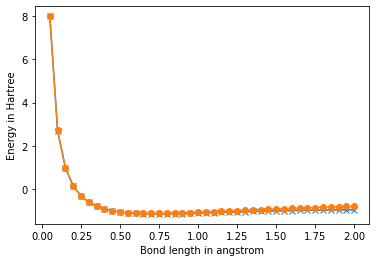

In [0]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.05
n_points = 40

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point)
    bond_lengths += [bond_length]
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run pyscf.
    molecule = ofpyscf.run_pyscf(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()


In [0]:
# interpolate with known ground state energy
calculated_bond_length = bond_lengths[13]+(ground_energy-fci_energies[13])*((bond_lengths[14]-bond_lengths[13])/(fci_energies[14]-fci_energies[13]))
print('Calculated bond length: {}'.format(calculated_bond_length))

Calculated bond length: 0.7589890445944005


## X. References
[OpenFermion docs](https://github.com/quantumlib/OpenFermion)

[OpenFermion arXiv paper, 2019](https://arxiv.org/pdf/1710.07629.pdf)

[Møller and Plesset paper, 1934](https://journals.aps.org/pr/pdf/10.1103/PhysRev.46.618)

[Psi4 docs](http://www.psicode.org/psi4manual/master/detci.html)

[Pyscf docs](https://sunqm.github.io/pyscf/)